In [19]:
import os
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import albumentations as A
import copy
import pickle
import random

from mmseg.datasets import build_dataset
from glob import glob
plt.rcParams['axes.grid'] = False

In [11]:
#### 데이터 경로 ####
data_path = '../input/mmseg/'

In [12]:
classes = ['Background', 'General trash', 'Paper', 'Paper pack', 'Metal', 'Glass', 'Plastic','Styrofoam', 'Plastic bag', 'Battery', 'Clothing']
palette = [
    [0, 0, 0],
    [192, 0, 128], [0, 128, 192], [0, 128, 64],
    [128, 0, 0], [64, 0, 128], [64, 0, 192],
    [192, 128, 64], [192, 192, 128], [64, 64, 128], [128, 0, 192],[128,64,64]
    ]
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)

In [46]:
def label_mask(mask):
    mask = mask[:,:,-1]
    label = np.zeros((mask.shape[0], mask.shape[1], 3)).astype(np.uint8)
    for i in range(1, 11):
        label[mask == i] = palette[i]
    return label

def show_data(file_path,image_id):
    mask = cv2.imread(os.path.join(file_path,'annotations/train/', image_id +'.png'))
    image = cv2.imread(os.path.join(file_path,'images/train/', image_id +'.jpg'))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(image)
    ax[0].axis('off')
    ax[1].imshow(label_mask(mask))
    ax[1].axis('off')
    plt.show()

def check_data(file_path):
    image_paths = glob(os.path.join(file_path,'images/train','*.jpg'))
    annotation_paths = glob(os.path.join(file_path,'annotations/train','*.png'))
    print(f'train_image_count : {len(image_paths)}')
    print(f'train_annotation_count : {len(annotation_paths)}')

def convert(datasets):
    sample = datasets
    img = sample['img'].data.cpu().numpy()
    img = np.einsum("chw -> hwc", img)
    img =  img * sample['img_metas'].data['img_norm_cfg']['std'] + sample['img_metas'].data['img_norm_cfg']['mean']
    img = img.astype(np.uint8)
    
    gt_seg_map = sample['gt_semantic_seg'].data.cpu().numpy().squeeze()
    label = np.zeros((gt_seg_map.shape[0], gt_seg_map.shape[1], 3)).astype(np.uint8)
    for i in range(1, 11):
        label[gt_seg_map == i] = palette[i]
    mask = np.zeros((gt_seg_map.shape[0], gt_seg_map.shape[1], 3)).astype(np.uint8)
    for i in range(3):
        mask[:,:,i] = gt_seg_map

    return img,mask,label

In [15]:
###################### modified root ######################
data_root = data_path
img_root = data_root + 'images/train'
ann_root = data_root + 'annotations/train'
###################### modified root ######################

train_pipeline = [
    dict(type='RandomFlip', prob=0),
    dict(type='Resize', img_scale=(512, 512)),
    dict(type='Normalize', **img_norm_cfg),
    dict(type='Pad', size=(512,512), pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

dataset_type = 'CustomDataset'
data = dict(
    samples_per_gpu=1,
    workers_per_gpu=4,
    train=dict(
        type = 'MultiImageMixDataset',
        dataset = dict(
            type=dataset_type,
            classes=classes,
            palette=palette,
            data_root=data_root,
            img_dir=img_root,
            ann_dir=ann_root,
            pipeline=[dict(type='LoadImageFromFile'),
                      dict(type='LoadAnnotations')
            ]),
            pipeline=train_pipeline),)

In [ ]:
############################### Data Transform ###############################
datasets = build_dataset(data['train'])

### 각 이미지에 추가할 object 목록 만들기

In [8]:
### 저장할 dict 정의 ###
classdict = {
    1: [], # 1: 'General trah'
    # 3: [], # 3: 'Paper pack'
    # 4: [], # 4: 'Metal'
    # 5: [], # 5: 'Glass'
    # 6: [], # 6: 'Plastic'
    # 7: [], # 7: 'Styrofoam'
    # 9: [], # 9: 'Battery'
    # 10: [], # 10: 'Clothing'
}

### 이미지 크기에 따른 transform 정의 ###
tfms_to_small = A.Compose([
    A.Resize(256, 256),
    A.PadIfNeeded(512, 512, border_mode=0),
    A.RandomRotate90(p=1.0),
    A.HorizontalFlip(p=1.0),
    A.VerticalFlip(p=0.5),
    A.Resize(512, 512)
])
tfms_to_big = A.Compose([
    A.CropNonEmptyMaskIfExists(256, 256, ignore_values=[0]),
    A.RandomRotate90(p=1.0),
    A.HorizontalFlip(p=1.0),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=1.0),
    A.Resize(512, 512)
])
tfms = A.Compose([
    A.RandomRotate90(p=1.0),
    A.HorizontalFlip(p=1.0),
    A.VerticalFlip(p=0.5),
    A.Resize(512, 512)
])

# datasets의 image, mask 확인 
for i in range(len(datasets)):
    img, masks, category = convert(datasets[i])
    mask = masks[:,:,-1]
    
    # 제외할 라벨들은 mask를 0으로 변경
    # mask[mask == 1] = 0
    mask[mask == 2] = 0
    mask[mask == 3] = 0
    mask[mask == 4] = 0
    mask[mask == 5] = 0
    mask[mask == 6] = 0
    mask[mask == 7] = 0
    mask[mask == 8] = 0
    mask[mask == 9] = 0
    mask[mask == 10] = 0

    # mask에 남아있는 label들
    class_type = np.unique(mask)
    
    # 0만 남아있다면 제외
    if len(class_type) == 1:
        continue

    # mask를 3차원으로 늘리기
    mask3d = np.dstack([mask]*3)
    
    # 늘린 mask3d가 0(False) 이면 img, 그 외에는 0으로 설정
    # 따라서 해당 object 부분만 제외되고 나머지 배경이 출력됨
    res = np.where(mask3d, 0, img)

    # 위와 반대로 해당 object만 남기고 나머지는 배경으로 처리
    res1 = cv2.bitwise_and(img, img, mask=mask)
    
    ### res, res1 결과 확인
    # fig, axes = plt.subplots(1, 2)
    # axes[0].imshow(res)
    # axes[1].imshow(res1)
    # break
    
    # 배경을 제외한 나머지 class 들 for문 돌리기
    for j in class_type:
        # 배경 제외
        if j == 0:
            continue
        
        # mask 복사
        temp_mask = copy.deepcopy(mask)
        
        # 해당 class(j)가 아니면 모두 제외
        temp_mask[temp_mask != j] = 0    
        
        # object의 크기가 400보다 작은 경우 무시
        if (np.sum(temp_mask != 0)) < 400:
            continue

        # 추가할 object에 대한 mask 구하기
        temp = copy.deepcopy(res1)
        temp = cv2.bitwise_and(temp, temp, mask=temp_mask)

        # 3개의 채널을 모두 더하여 크기를 구하고, 각 기준별로 위에서 정의했던 transform 적용
        if np.sum(temp != 0) > 20000:
            transformed = tfms_to_small(image=temp, mask=temp_mask)
            mask = transformed['mask']
            temp = transformed['image']
            
        elif np.sum(temp != 0) < 5000:
            transformed = tfms_to_big(image=temp, mask=temp_mask)
            mask = transformed['mask']
            temp = transformed['image']     
            
        else:
            transformed = tfms(image=temp, mask=temp_mask)
            mask = transformed['mask']
            temp = transformed['image']
        
    # res1, temp 결과 비교
    # fig, axes = plt.subplots(1, 2)
    # axes[0].imshow(res)
    # axes[1].imshow(temp)
    # break
        
        # 변환된 temp의 크기가 400보다 크면 저장
        if np.sum(temp != 0) >= 400: 
            classdict[j].append(temp)

# pickle로 저장
with open('classdict.pickle','wb') as fw:
    pickle.dump(classdict, fw)

### 저장했던 object들 정보 불러오기

In [3]:
with open('classdict.pickle','rb') as f:
    classdict = pickle.load(f)

In [4]:
# 총 object 개수
num =[1]
count = 0
for i in num:
    count += len(classdict[i])
print(count)

969


### 기존의 이미지와 해당 object들 섞기

In [ ]:
print('################### Mix 이미지 추가 전 ###################')
check_data(data_path)

for i in range(len(datasets)):
    # 기존의 데이터 정보 불러오기
    img, masks, category = convert(datasets[i])
    img_name = datasets[i]['img_metas'].data['ori_filename'][:4]
    new_img_name = '3' + img_name
    masks = masks[:,:,-1]

    # 추가할 라벨 목록
    num = num

    # 랜덤으로 추가할 라벨 선택
    label = random.choice(num)

    # object 목록에서 라벨에 맞는 랜덤한 이미지 인덱스 가져오기 
    idx = np.random.randint(len(classdict[label]))

    # 추가할 이미지 가져오기
    aug_img = classdict[label][idx]
    
    # 랜덤 위치 조정을 위한 좌표 구하기
    ## 윤곽 좌표 추출
    contours , _ = cv2.findContours(aug_img[:,:,0], cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

    ## 외접하는 최소 box 좌표
    contour = contours[0]
    x,y,w,h = cv2.boundingRect(contour)

    ## 랜덤으로 삽입할 위치 좌표 설정
    mx,my = np.random.randint(-x,512-(x+w)),np.random.randint(-y,512-(y+h))
    m = np.float32([[1,0,mx],[0,1,my]])

    ### object box 확인하기 ###
    ### 이미지 저장할땐 주석처리 필수 ###
    ### 주석처리 안할 시 박스 선까지 함께 섞임 ###
    ### 주석해제 하시고 맨 아래 Mix 이미지 확인하기 실행시키시면 박스도 같이 출력됩니다. ###
    # cv2.rectangle(aug_img, (x,y), (x+w,y+h), (255,0,0),3 )

    # 추가할 image와 mask 정의
    aug_img = cv2.warpAffine(aug_img,m,(aug_img.shape[1],aug_img.shape[0]))
    aug_mask = np.zeros((512,512))
    aug_mask[aug_img[:,:,0] != 0] = label

    # 기존 이미지와 추가할 object Mix하기
    img[aug_img!=0] = aug_img[aug_img!=0]
    masks[aug_mask!=0] = aug_mask[aug_mask!=0]
    

    ### Mix된 이미지 확인하기 ###
    # fig, axes = plt.subplots(1, 2)
    # axes[0].imshow(img)
    # axes[1].imshow(masks)
    # if i == 2:
    #     break

    # 이미지 저장
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.imwrite(os.path.join(data_path,'images/train',new_img_name+'.jpg'),img)
    cv2.imwrite(os.path.join(data_path,'annotations/train',new_img_name+'.png'),masks)

print('################### Mix 이미지 추가 후 ###################')
check_data(data_path)

### 저장된 이미지 확인

In [13]:
check_data(data_path)

train_image_count : 5236
train_annotation_count : 5236


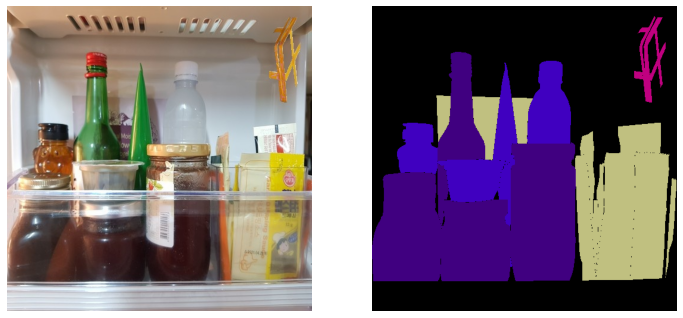

In [47]:
show_data('../input/mmseg','30000')